In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import os

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

In [2]:
def mkdir(save_dir):
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    return save_dir

def smooth(x, kernel_size=5):
    if kernel_size == 1 or len(x)<kernel_size:
        return x
    else:
        assert kernel_size % 2 != 0
        x_shape = x.shape
        x_tmp = np.array([x[i:x_shape[0]-kernel_size+i+1] for i in range(kernel_size)])
        edge1 = x[:int((kernel_size-1)/2)]
        edge2 = x[-int((kernel_size-1)/2):]
        x_out = np.concatenate((edge1, np.mean(x_tmp, 0),edge2),0)
        assert x_shape == x_out.shape
        return x_out #np.mean(np.array(x).reshape(-1, kernel_size),1)


In [3]:
model_path = './top_landscape/models/'
data_path = "./top_landscape/data/"

data_config = "./top_landscape/particle_transformer/data/TopLandscape/top_kin.yaml"
model_config = "./top_landscape/particle_transformer/networks/example_ParticleNet.py"

log_path = './top_landscape/logs/'

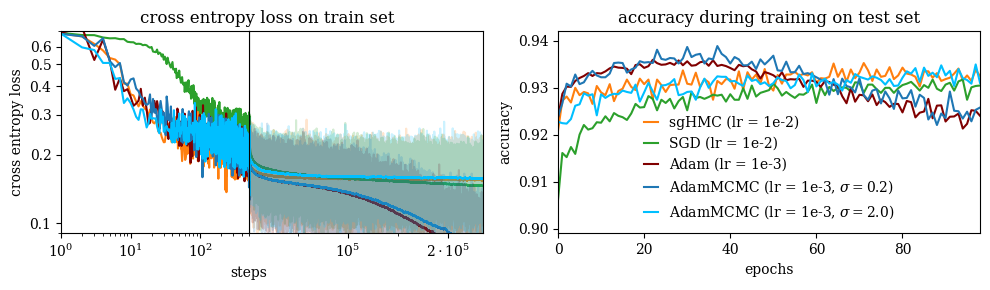

In [ ]:
## losses

lr = 0.001
min_lr = 1e-6
lr_decay = 1# 0.998 # 0.995
temp = 1.
sigma = 0.2
sigma_factor = 1
betas_adam = (0.99,0.99)

optim_str = 'Adam'
optim_str += f'betas{betas_adam}'

sigma_adam_dir_denom = 100
m_params = 366160
sigma_adam_dir =  m_params/sigma_adam_dir_denom

paths = [model_path + '/ParticleNet_sgHMC_lr0.01_C0.2_gauss_sig0_burn100',
         model_path + "/ParticleNet_sgd_lr0.01_opt[('betas', '(0.99, 0.99)')]",
         model_path + "/ParticleNet_adam_lr0.001_opt[('betas', '(0.99, 0.99)')]",
         model_path + '/ParticleNet_Adambetas(0.99, 0.99)MCMC_lr0.001_lrdecay1_temp1.0_sigma0.2_sigmaadam3661.6_sigmafactor1',
         model_path + '/ParticleNet_Adambetas(0.99, 0.99)MCMC_lr0.001_lrdecay1_temp1.0_sigma2.0_sigmaadam3661.6_sigmafactor1',
         ]
      
plt_strs = ['sgHMC (lr = 1e-2)', 
            'SGD (lr = 1e-2)',
            'Adam (lr = 1e-3)',
            'AdamMCMC (lr = 1e-3, '+r'$\sigma = 0.2$)', 
            'AdamMCMC (lr = 1e-3, '+r'$\sigma = 2.0$)',
            ]
skips = [0]*len(paths)
colors = ["C1", 
          "C2", 
          "maroon",
          "C0", 
          "deepskyblue", 
         ]

keys = ["/Loss/train", 
        "/Acc/test_all_epochs"
        ]
fig, ax = plt.subplots(1, len(keys), figsize=(10,3))#, sharex = True)
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax[0])
ax_log = divider.append_axes("left", size="80%", pad=0, sharey=ax[0])

if not isinstance(ax, np.ndarray):
    ax = [ax]

for i_sg, (path, plt_str, skip, c) in enumerate(zip(paths, plt_strs, skips, colors)):

    for i_k, key in enumerate(keys):
        y_plt = np.load(path + key + '.npy') 
        if 'sgHMC' in plt_str and key == "/Loss/train":
            y_plt /= 1210999
        s = 2401

        if "test" in key:
            ax[i_k].plot(y_plt[skip:], label = plt_str, color = c, )
            ax[i_k].set_xlim(1,100)
        elif i_k ==0:
            bd = 500
            ax_log.plot(y_plt[skip:], color = c)
            ax_log.set_xlim(1,bd)
            ax_log.set_xscale('log')
            ax[i_k].plot(y_plt[skip:], color = c, alpha =.2)
            ax[i_k].plot(smooth(y_plt, s)[skip:], label = plt_str, color = c, )
            ax[i_k].set_xlim(bd,2400*98+1)
        else:
            ax[i_k].plot(y_plt[skip:], color = c, alpha =.2)
            ax[i_k].plot(smooth(y_plt, s)[skip:], label = plt_str, color = c, )
            ax[i_k].set_xlim(1,2400*98+1)

    # try:
    #     print('\n', plt_str, '\n \n')
    #     for tag in ['true top', 'true qcd', 'false top', 'false qcd']:
    #         print(tag)
    #         preds = np.load(path +"/preds.npy")
    #         labels = np.load(path +"/labels.npy")
    #         mask = np.bitwise_and((preds == ('qcd' in tag)), (labels == (('qcd' in tag) == ('true' in tag))))
    #         print(np.sum(mask))
            
    #         post_pred_entropy = np.load(path +"/post_pred_entropy.npy")[mask]
    #         print("post_pred_entropy: ", np.quantile(post_pred_entropy, (0.25,0.5,0.75)))

    #         entropy_expect = np.load(path +"/entropy_expect.npy")[mask]
    #         print('entropy_expect_arr: ', np.quantile(entropy_expect, (0.25,0.5,0.75)))

    #         mutual_info = np.load(path +"/mutual_info.npy")[mask]
    #         print('mutual_info_arr: ', np.quantile(mutual_info, (0.25,0.5,0.75)))s
    # except:
    #     print('couldnt calculate quantiles')

ax[1].legend(loc = 'lower center', handlelength = 1.0, frameon = False)
ax_log.set_title('cross entropy loss on train set', x=1.1)
ax_log.set_ylabel('cross entropy loss')
ax_log.set_xlabel('steps', x=1.)

#ax[1].set_ylabel('accuracy during training')
ax[1].set_title('accuracy during training on test set')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epochs')

ax[0].set_ylim(0.09,0.7)
#ax[0].set_xlim(1,1.8e5)
#ax[1].set_ylim(0.5,1.0)
ax[1].set_ylim(0.899,0.942)
ax[1].set_xlim(0,98)
ax[0].set_yscale('log')
ax[0].set_yticks([0.1,0.2,0.3,0.4,0.5,0.6], labels = ['0.1', '0.2','0.3','0.4','0.5','0.6'])
ax[0].set_xticks([1e5, 2e5], labels = [r'$10^5$', r'$2\cdot10^5$'])
ax[0].set_xticks([5e4, 15e4], minor = True)

fig.tight_layout()
plt.savefig("./figs/01_convergence_compare.png")